### Introduction

This notebook is an experiment of building a model that will predict if a rookie player will last at least 5 years in the league based on his stats.

In the National Basketball Association (NBA), a rookie is any player who has never played a game in the NBA until that year. At the end of the season the NBA awards the best rookie with the NBA Rookie of the Year Award.

Moving to the NBA league is a big deal for any basketball player. Sport commentators and fans are very excited to follow the start of their careers and guess how they will perform in the future.

In this experiment, LogisticRegression model is used.

### Import the libraries

In [31]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import StandardScaler, PolynomialFeatures
import os
import sys
sys.path.append(os.path.abspath('..'))
from src.common_lib import DataReader, NBARawData
from src.models.aj_metrics import confusion_matrix, plot_roc

from sklearn.linear_model import LogisticRegression 
from sklearn.metrics import accuracy_score, roc_curve, auc
import matplotlib.pyplot as plt
from joblib import dump
from sklearn.model_selection import train_test_split, GridSearchCV

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Load the data

In [3]:
# Instantiate the custom data reader class
data_reader = DataReader()

# Load Raw Train Data
train_df = data_reader.read_data(NBARawData.TRAIN)

# Load Test Raw Data
test_df = data_reader.read_data(NBARawData.TEST)

### Class Balance Check on Raw Data

Propotion:  0.2 :1


<AxesSubplot:title={'center':'Count -Target'}>

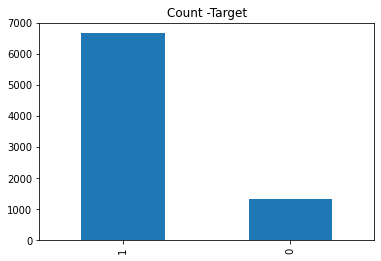

In [4]:
target_count = train_df["TARGET_5Yrs"].value_counts()
print('Propotion: ', round(target_count[0]/ target_count[1], 2), ":1")
target_count.plot(kind='bar', title = 'Count -Target')

### Scaling with Standard Scaler

In [5]:
## Scaling
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
df_cleaned = train_df.copy()
df_cleaned.columns = df_cleaned.columns.str.strip()
target = df_cleaned.pop('TARGET_5Yrs')

train_df_scaled = scaler.fit_transform(df_cleaned)
train_df_scaled

array([[ 0.93005882, -1.73183431,  1.00610018, ...,  1.1072419 ,
        -0.05507101,  0.47321012],
       [-0.38091406, -1.7314013 ,  0.71400493, ..., -0.36478721,
         0.43214835,  0.1966711 ],
       [-0.28687803, -1.73096829,  1.29819543, ..., -0.6101254 ,
        -0.05507101, -0.90948499],
       ...,
       [-0.33188458,  1.73096829,  1.29819543, ...,  1.35258008,
        -0.05507101,  0.74974914],
       [-1.39921865,  1.7314013 , -1.38908087, ..., -0.85546358,
         0.06673383, -1.0477545 ],
       [-0.99491401,  1.73183431, -0.80489037, ...,  0.61656553,
        -0.66409522,  0.1966711 ]])

### Select Features

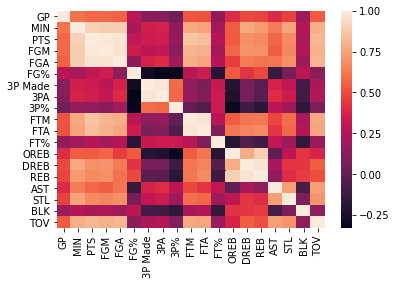

In [6]:
train_df_scaled = pd.DataFrame(train_df_scaled)
train_df_scaled.columns = df_cleaned.columns

selected_features = data_reader.select_feature_by_correlation(train_df_scaled)

In [7]:
selected_features

Index(['GP', 'MIN', 'FG%', '3P Made', '3P%', 'FTM', 'FT%', 'OREB', 'DREB',
       'AST', 'STL', 'BLK', 'TOV'],
      dtype='object')

### Split Train and Test on Scaled Data with Selected Features

In [8]:
train_df_scaled  = train_df_scaled[selected_features]

X_train, X_val, y_train, y_val = train_test_split(train_df_scaled, target, test_size = 0.2, random_state=8 )
X_train

,GP,MIN,FG%,3P Made,3P%,FTM,FT%,OREB,DREB,AST,STL,BLK,TOV
3617,0.071395,-0.523427,-0.261394,-1.209483,-0.480167,0.008072,-0.207657,-0.608229,-0.336533,-0.755595,-0.610125,-0.176876,-0.771215
1120,1.064519,0.248843,0.031048,0.352736,-0.467668,0.439993,0.731958,0.791937,1.315603,-0.681844,-0.119449,-0.176876,0.058402
3873,-0.746471,-1.452389,-1.333681,-0.688743,-1.417540,-1.287692,-0.265185,-1.244669,-1.414013,-0.091830,-0.610125,-0.664095,-1.324294
153,0.538748,0.080958,-0.683810,-0.428374,0.357221,-0.531830,-2.201944,-0.480941,-0.121037,-0.386837,-0.364787,-0.055071,-0.494676
2960,-1.038567,0.125727,-0.407615,-0.428374,-1.392544,-0.315869,-0.897987,-0.099078,-0.480197,-0.091830,-0.610125,0.066734,0.749749
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2181,0.655586,3.114075,0.112281,1.394215,1.413328,1.843737,-0.322712,1.046513,2.895908,1.309452,1.843256,0.066734,2.408983
2409,-0.220700,-0.422696,-1.772344,0.613106,-0.330187,-0.099909,-1.444499,-0.480941,-0.695693,-0.091830,0.616566,-0.176876,-0.771215
2033,-0.454376,-0.333157,-0.033940,0.873476,0.775914,-0.747791,0.127920,0.028210,0.094459,-0.460589,-0.364787,0.066734,-0.632946
1364,1.648710,3.281959,0.226009,0.352736,-1.261311,1.951717,-0.476119,2.446680,3.111404,1.899466,0.616566,0.432148,0.473210


In [9]:
### Before Sampling Classification Count
print(sum(y_train == 1))
print(sum(y_train == 0))

5326
1074


### Re-sampling -  Over Sampling

1343
1343


<AxesSubplot:title={'center':'Count'}>

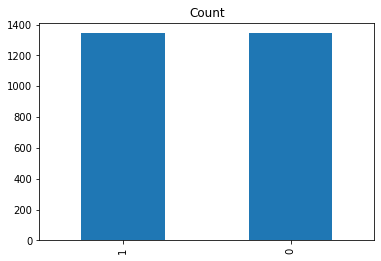

In [23]:
### SMOTE
from imblearn.over_sampling import SMOTE

sm = SMOTE(random_state = 2)
X_train_res, y_train_res = sm.fit_sample(X_train, y_train.ravel())
X_val_res, y_val_res = sm.fit_sample(X_val, y_val.ravel())

print(sum(y_val_res == 1))
print(sum(y_val_res == 0))

pl = pd.DataFrame(y_val_res)
pl.columns = ['Target']

pl.Target.value_counts().plot(kind="bar", title="Count")

### Build The Model - Logistic Regression with Grid Search

In [16]:
## No use of Poly Features
parameters = {"C": np.linspace(1,10,10)}
lr = LogisticRegression()
clf = GridSearchCV(lr, parameters, cv = 5,verbose=5, n_jobs=3)
clf.fit(X_train_res, y_train_res.ravel())

Fitting 5 folds for each of 10 candidates, totalling 50 fits


GridSearchCV(cv=5, estimator=LogisticRegression(), n_jobs=3,
             param_grid={'C': array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.])},
             verbose=5)

In [17]:
clf.best_params_

{'C': 1.0}

### Logistic Regression with Penalty

In [13]:
lr1 = LogisticRegression(C=1, penalty='l2', verbose=5)
lr1.fit(X_train_res, y_train_res.ravel())

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s finished


LogisticRegression(C=1, verbose=5)

### Accuracy Check on Train Set

accuracy_score: 0.6540555764175742
        pred:0  pred:1
true:0    3568    1758
true:1    1927    3399


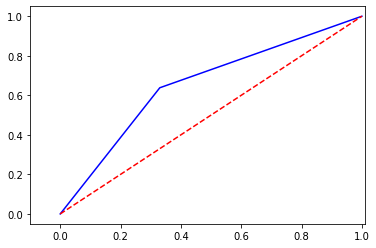

roc_auc: 0.6540555764175742


In [40]:
y_prob=lr1.predict_proba(X_train_res)[:,1]

# Check Accuracy Score
y_pred=lr1.predict(X_train_res)
print("accuracy_score:",accuracy_score(y_train_res, y_pred))

#print(y_train.value_counts())
#print(y_val.value_counts())
print(confusion_matrix(y_train_res, y_pred))

## Plotting ROC
roc_auc = plot_roc(y_train_res, y_pred)
print("roc_auc:",roc_auc)

accuracy_score 0.6548771407297096
        pred:0  pred:1
true:0     921     422
true:1     505     838


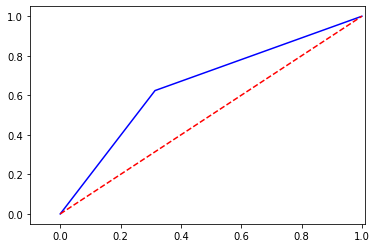

roc_auc 0.6548771407297096


In [38]:
y_prob=lr1.predict_proba(X_val_res)[:,1]

## Check Accuracy Score
y_pred=lr1.predict(X_val_res)
print("accuracy_score:", accuracy_score(y_val_res, y_pred))
print(confusion_matrix(y_val_res, y_pred))

## Plotting ROC
roc_auc = plot_roc(y_val_res, y_pred)
print("roc_auc:",roc_auc)

In [ ]:
# Kaggle - Smote with Imbalanced Data